# Data Preprocessing

1. Import Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

2. Load Data

In [2]:
ratings = pd.read_csv('data/ratings.csv')

In [3]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
movies = pd.read_csv('data/movies.csv')

In [5]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


3. Exploratory data analysis

In [6]:
n_ratings = len(ratings)
n_movies = ratings['movieId'].nunique()
n_users = ratings['userId'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 100836
Number of unique movieId's: 9724
Number of unique users: 610
Average number of ratings per user: 165.3
Average number of ratings per movie: 10.37


+ Distribution of movie ratings

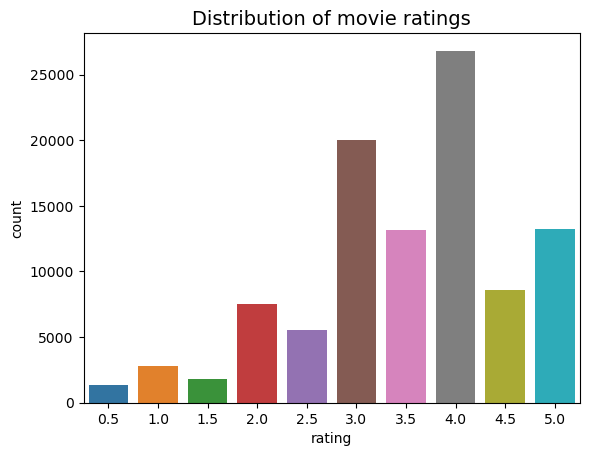

In [7]:
sns.countplot(x= 'rating', data=ratings)
plt.title("Distribution of movie ratings", fontsize=14)
plt.show()

In [8]:
print(f"Mean global rating: {round(ratings['rating'].mean(),2)}.")

Mean global rating: 3.5.


In [9]:
mean_ratings = ratings.groupby('userId')['rating'].mean()   
#The groupby() function is a powerful tool in pandas that allows you to split a DataFrame into groups based on a specified criterion. 
#In this case, the criterion is the 'userId' column. The function takes the column to group by as its first argument, which is 'userId' in this case.
#Overall, this code is using the groupby() function to group the data by 'userId' and calculate the mean ratings for each user.
print(f"Mean rating per user: {round(mean_ratings.mean(),2)}.")

Mean rating per user: 3.66.


+ Which movies are frequently rated?

In [10]:
movie_ratings = ratings.merge(movies, on = 'movieId' )  #merge the ratings and movies dataframes on the 'movieId' column
movie_ratings['title'].value_counts()[0:10] #count the number of ratings for each movie and display the top 10

Forrest Gump (1994)                          329
Shawshank Redemption, The (1994)             317
Pulp Fiction (1994)                          307
Silence of the Lambs, The (1991)             279
Matrix, The (1999)                           278
Star Wars: Episode IV - A New Hope (1977)    251
Jurassic Park (1993)                         238
Braveheart (1995)                            237
Terminator 2: Judgment Day (1991)            224
Schindler's List (1993)                      220
Name: title, dtype: int64

+ What are the highest and lowest rating movies

In [11]:
mean_ratings = ratings.groupby('movieId')[['rating']].mean()
lowest_rated = mean_ratings['rating'].idxmin()

movies[movies['movieId'] == lowest_rated ]

,movieId,title,genres
2689,3604,Gypsy (1962),Musical


In [12]:
highest_rated = mean_ratings['rating'].idxmax()
movies[movies['movieId'] == highest_rated ]

,movieId,title,genres
48,53,Lamerica (1994),Adventure|Drama


+ How many ratings does Lamerica have?

In [13]:
ratings[ratings['movieId']==highest_rated]

,userId,movieId,rating,timestamp
13368,85,53,5.0,889468268
96115,603,53,5.0,963180003


`Lamerica` may be the "highest" rated movie, but it only has 2 ratings. A better approach for evaluating movie popularity is to do look at the [Bayesian average](https://en.wikipedia.org/wiki/Bayesian_average).

#### Bayesian Average

[Bayesian Average](https://en.wikipedia.org/wiki/Bayesian_average) is defined as:

$r_{i} = \frac{C \times m + \Sigma{\text{reviews}}}{C+N}$

where $C$ represents our confidence, $m$ represents our prior, and $N$ is the total number of reviews for movie $i$. 

- $C$ represents "the typical data set size". In this case, $C$ will be the average number of ratings for a given movie.
- $m$ represents the average rating across all movies 

In [14]:
movie_stats = ratings.groupby('movieId')['rating'].agg(['count','mean']) 
#Group movies id and rating ( only count and mean )
movie_stats.head()

,count,mean
movieId,,
1,215,3.920930
2,110,3.431818
3,52,3.259615
4,7,2.357143
5,49,3.071429


In [15]:
C = movie_stats[ 'count' ].mean()   # mean of count ( avg number of ratings )
m = movie_stats[ 'mean' ].mean()    # Average ratings on all movies

print(f"Average number of ratings for a given movie: {C:.2f}")
print(f"Average rating for a given movie: {m:.2f}")

def bayesian_avg(ratings):
    bayesian_avg = (C*m + ratings.sum())/(C+ratings.count())
    return round(bayesian_avg, 3)

Average number of ratings for a given movie: 10.37
Average rating for a given movie: 3.26


In [16]:
lamerica = pd.Series([5,5])
bayesian_avg(lamerica)

3.543

+ Apply Bayesian Average for all movies

In [17]:
bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')

In [18]:
movie_stats = movie_stats.merge(movies[['movieId', 'title']])
movie_stats.sort_values(by = 'bayesian_avg', ascending=False).head(10)

,movieId,count,mean,bayesian_avg,title
277,318,317,4.429022,4.392,"Shawshank Redemption, The (1994)"
659,858,192,4.289062,4.236,"Godfather, The (1972)"
2224,2959,218,4.272936,4.227,Fight Club (1999)
224,260,251,4.231076,4.193,Star Wars: Episode IV - A New Hope (1977)
46,50,204,4.237745,4.191,"Usual Suspects, The (1995)"
921,1221,129,4.259690,4.185,"Godfather: Part II, The (1974)"
461,527,220,4.225000,4.182,Schindler's List (1993)
6693,58559,149,4.238255,4.175,"Dark Knight, The (2008)"
913,1213,126,4.250000,4.175,Goodfellas (1990)
897,1196,211,4.215640,4.171,Star Wars: Episode V - The Empire Strikes Back...


In [19]:
movie_stats.sort_values('bayesian_avg', ascending=True).head(10)

,movieId,count,mean,bayesian_avg,title
1172,1556,19,1.605263,2.190,Speed 2: Cruise Control (1997)
2679,3593,19,1.657895,2.224,Battlefield Earth (2000)
1372,1882,33,1.954545,2.267,Godzilla (1998)
1144,1499,27,1.925926,2.297,Anaconda (1997)
1988,2643,16,1.687500,2.307,Superman IV: The Quest for Peace (1987)
1311,1760,10,1.350000,2.324,Spice World (1997)
3799,5323,8,1.187500,2.359,Jason X (2002)
2103,2798,12,1.583333,2.362,Problem Child (1990)
5260,8666,9,1.333333,2.366,Catwoman (2004)
2028,2701,53,2.207547,2.380,Wild Wild West (1999)


4. A Glimpse at Movie Genres

The movies dataset needs to be cleaned in two ways:

- `genres` is expressed as a string with a pipe `|` separating each genre. We will manipulate this string into a list, which will make it much easier to analyze.
- `title` currently has (year) appended at the end. We will extract year from each title string and create a new column for it.

In [20]:
movies['genres'] = movies['genres'].apply( lambda x: x.split('|') )
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


+ How many genres are there?

In [21]:
from collections import Counter

genre_frequency = Counter(g for genres in movies['genres'] for g in genres )    
#The Counter class from the collections module is a dictionary subclass that counts hashable objects.
# In this case, it is counting different genres in the list of genres for each movies

print(f"There are {len(genre_frequency)} genres.")

genre_frequency

There are 20 genres.


Counter({'Drama': 4361,
         'Comedy': 3756,
         'Thriller': 1894,
         'Action': 1828,
         'Romance': 1596,
         'Adventure': 1263,
         'Crime': 1199,
         'Sci-Fi': 980,
         'Horror': 978,
         'Fantasy': 779,
         'Children': 664,
         'Animation': 611,
         'Mystery': 573,
         'Documentary': 440,
         'War': 382,
         'Musical': 334,
         'Western': 167,
         'IMAX': 158,
         'Film-Noir': 87,
         '(no genres listed)': 34})

In [22]:
print("The 5 most common genres: \n", genre_frequency.most_common(5))

The 5 most common genres: 
 [('Drama', 4361), ('Comedy', 3756), ('Thriller', 1894), ('Action', 1828), ('Romance', 1596)]


+ Visualize popularity

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'Drama'),
  Text(1, 0, 'Comedy'),
  Text(2, 0, 'Thriller'),
  Text(3, 0, 'Action'),
  Text(4, 0, 'Romance'),
  Text(5, 0, 'Adventure'),
  Text(6, 0, 'Crime'),
  Text(7, 0, 'Sci-Fi'),
  Text(8, 0, 'Horror'),
  Text(9, 0, 'Fantasy'),
  Text(10, 0, 'Children'),
  Text(11, 0, 'Animation'),
  Text(12, 0, 'Mystery'),
  Text(13, 0, 'Documentary'),
  Text(14, 0, 'War'),
  Text(15, 0, 'Musical'),
  Text(16, 0, 'Western'),
  Text(17, 0, 'IMAX'),
  Text(18, 0, 'Film-Noir'),
  Text(19, 0, '(no genres listed)')])

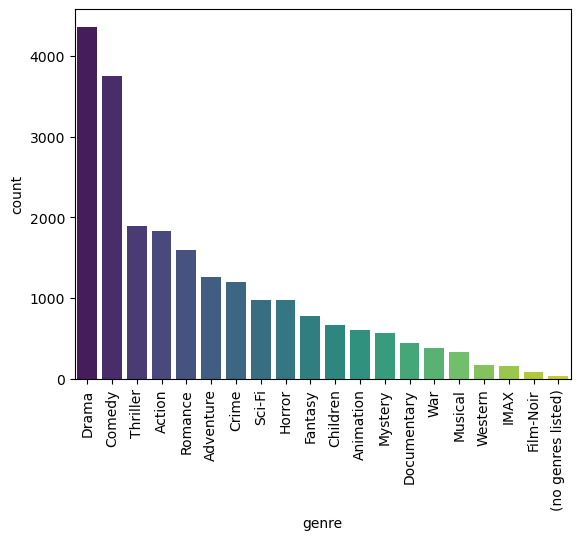

In [23]:
genre_frequency_df = pd.DataFrame([genre_frequency]).T.reset_index() #T is transverse so that it displays as a column not a row
genre_frequency_df.columns = ['genre', 'count']

sns.barplot(x ='genre', y ='count', data = genre_frequency_df.sort_values(by='count', ascending=False), palette= 'viridis')
plt.xticks(rotation = 90) #rotate the x-axis labels

5. Process data
We are going to use a technique called colaborative filtering to generate recommendations for users. This technique is based on the premise that similar people like similar things. 

The first step is to transform our data into a user-item matrix, also known as a "utility" matrix. In this matrix, rows represent users and columns represent movies. The beauty of collaborative filtering is that it doesn't require any information about the users or the movies user to generate recommendations.


The `create_X()` function outputs a sparse matrix $X$ with four mapper dictionaries:

- **user_mapper**: maps user id to user index
- **movie_mapper**: maps movie id to movie index
- **user_inv_mapper**: maps user index to user id
- **movie_inv_mapper**: maps movie index to movie id

We need these dictionaries because they map which row/column of the utility matrix corresponds to which user/movie id.

Our $X$ (user-item) matrix is a [scipy.sparse.csr_matrix](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html) which stores the data sparsely.

In [24]:
from scipy.sparse import csr_matrix

def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe containing 3 columns (userId, movieId, rating)
    
    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """
    M = df['userId'].nunique()
    N = df['movieId'].nunique()

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(M))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(N))))
    
    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["movieId"])))
    
    user_index = [user_mapper[i] for i in df['userId']]
    item_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df["rating"], (user_index,item_index)), shape=(M,N))    
    
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings)

In [25]:
X.shape

(610, 9724)

6. Evaluating sparsity

Here, we calculate sparsity by dividing the number of stored elements by total number of elements. The number of stored (non-empty) elements in our matrix ([nnz](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.nnz.html)) is equivalent to the number of ratings in our dataset. If data is too sparse, you cannot use collaborate filtering

In [26]:
n_total = X.shape[0]*X.shape[1] #total number of elements in the matrix
n_ratings = X.nnz #number of non-zero elements in the matrix
sparsity = n_ratings/n_total
print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 1.7%


`csr_matrix.nnz` counts the stored values in our sparse matrix. The rest of our cells are empty.

The **cold start problem** is when there are new users and movies in our matrix that do not have any ratings. In our Movielens dataset, all users and movies have at least one rating but in general, it's useful to check which users and movies have few interactions.

In [27]:
n_ratings_per_user = X.getnnz(axis=1)   #get the number of non-zero elements in each row (i.e. for each user)
len(n_ratings_per_user)

610

In [28]:
print(f"Most active user rated {n_ratings_per_user.max()} movies.")
print(f"Least active user rated {n_ratings_per_user.min()} movies.")

Most active user rated 2698 movies.
Least active user rated 20 movies.


In [29]:
n_ratings_per_movie = X.getnnz(axis=0)   #get the number of non-zero elements in each row (i.e. for each user)
len(n_ratings_per_movie)

9724

In [30]:
print(f"Most rated movie has {n_ratings_per_movie.max()} ratings.")
print(f"Least rated movie has {n_ratings_per_movie.min()} ratings.")

Most rated movie has 329 ratings.
Least rated movie has 1 ratings.


C:\Users\phana\AppData\Local\Temp\ipykernel_8640\3364525973.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(n_ratings_per_user, shade=True)
C:\Users\phana\AppData\Local\Temp\ipykernel_8640\3364525973.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(n_ratings_per_movie, shade=True)


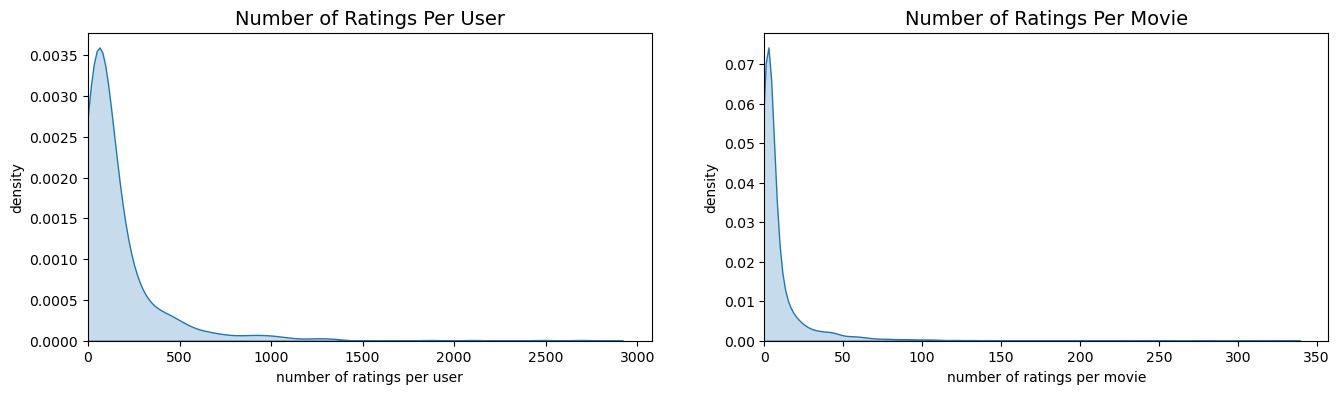

In [31]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
sns.kdeplot(n_ratings_per_user, shade=True)
plt.xlim(0)
plt.title("Number of Ratings Per User", fontsize=14)
plt.xlabel("number of ratings per user")
plt.ylabel("density")
plt.subplot(1,2,2)
sns.kdeplot(n_ratings_per_movie, shade=True)
plt.xlim(0)
plt.title("Number of Ratings Per Movie", fontsize=14)
plt.xlabel("number of ratings per movie")
plt.ylabel("density")
plt.show()

# Step-item Recommendations with kNN

We are going to find the $k$ movies that have the most similar user engagement vectors for movie $i$.

In [32]:
from sklearn.neighbors import NearestNeighbors

def find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k, metric='cosine'):
    """
    Finds k-nearest neighbours for a given movie id.
    
    Args:
        movie_id: id of the movie of interest
        X: user-item utility matrix
        k: number of similar movies to retrieve
        metric: distance metric for kNN calculations
    
    Output: returns list of k similar movie ID's
    """
    X = X.T # transpose the matrix so that rows represent movies and columns users
    neighbour_ids = []  #list to store the indices of the k-nearest neighbors
    
    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)
    # use k+1 since kNN output includes the movieId of interest
    kNN = NearestNeighbors(n_neighbors= k+1, algorithm="brute", metric=metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(movie_vec, return_distance=False)  #returns the indices of and distances to the neighbors of each point
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

In [33]:
similar_movies = find_similar_movies(1, X, movie_mapper, movie_inv_mapper, k=10)
similar_movies

[3114, 480, 780, 260, 356, 364, 1210, 648, 1265]

In [34]:
movie_titles = dict(zip(movies['movieId'], movies['title']))    #create a dictionary that maps movieId's to movie titles

movie_id = 1

similar_movies = find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, metric='cosine', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched Toy Story (1995):
Toy Story 2 (1999)
Jurassic Park (1993)
Independence Day (a.k.a. ID4) (1996)
Star Wars: Episode IV - A New Hope (1977)
Forrest Gump (1994)
Lion King, The (1994)
Star Wars: Episode VI - Return of the Jedi (1983)
Mission: Impossible (1996)
Groundhog Day (1993)


# Handling Cold-start problem

In [42]:
n_movies = movies['movieId'].nunique()
print(f"There are {n_movies} unique movies in our movies dataset.")

There are 9742 unique movies in our movies dataset.


In [44]:
genres = set(g for G in movies['genres'] for g in G)  #create a set of unique genres

for g in genres:
    movies[g] = movies.genres.transform(lambda x: int(g in x))
    
movie_genres = movies.drop(columns=['movieId', 'title','genres'])

In [45]:
movie_genres.head()

,War,Drama,Animation,Action,Musical,Horror,Adventure,Comedy,Crime,Documentary,Western,IMAX,(no genres listed),Film-Noir,Mystery,Children,Sci-Fi,Romance,Fantasy,Thriller
0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0
2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
3,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [46]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(movie_genres, movie_genres)  
#compute the cosine similarity between movies based on their genres for all pairs of movies
print(f"Dimensions of our genres cosine similarity matrix: {cosine_sim.shape}")

Dimensions of our genres cosine similarity matrix: (9742, 9742)


# Movie Finder Function

In [39]:
#%pip install fuzzywuzzy
from fuzzywuzzy import process

def movie_finder(title):
    all_titles = movies['title'].tolist()   #get a list of all movie titles
    closest_match = process.extractOne(title, all_titles)   
    # get the closest matching title with input title from the list of all titles
    return closest_match[0]

In [40]:
title = movie_finder('juminji')
title

'Jumanji (1995)'

In [41]:
movie_idx = dict(zip(movies['title'], list(movies.index)))  #create a dictionary that maps movie titles to movie indices
idx = movie_idx[title]
print(f"Movie index for Jumanji: {idx}")

Movie index for Jumanji: 1


In [47]:
n_recommendations=10
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)  #sort the movies based on the cosine similarity scores

In [48]:
print(f"Because you watched {title}:")
movies['title'].iloc[similar_movies]    #display the top 10 similar movies. iloc is used to index the movies dataframe

Because you watched Jumanji (1995):


3114    Greatest Story Ever Told, The (1965)
480                 Terminal Velocity (1994)
780                        Cinderella (1950)
260                         Quiz Show (1994)
356             Age of Innocence, The (1993)
364             Beverly Hills Cop III (1994)
1210            187 (One Eight Seven) (1997)
648                    Chain Reaction (1996)
1265                    Sliding Doors (1998)
Name: title, dtype: object

+ Function to input a name of movie to print out similar ones

In [49]:
def get_content_based_recommendations(title_string, n_recommendations=10):
    title = movie_finder(title_string)  #get the closest matching movie title
    idx = movie_idx[title]  #get the movie index for the input title
    sim_scores = list(enumerate(cosine_sim[idx]))   #get the cosine similarity scores for the movie of interest
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)   #sort the movies based on the cosine similarity scores
    sim_scores = sim_scores[1:(n_recommendations+1)]    #get the top n_recommendations
    similar_movies = [i[0] for i in sim_scores]  #get the indices of the top n_recommendations
    print(f"Because you watched {title}:")
    print(movies['title'].iloc[similar_movies]) #display the top n_recommendations similar movies

# Testing

In [50]:
get_content_based_recommendations('toy story', 5)

Because you watched Toy Story (1995):
1706                                       Antz (1998)
2355                                Toy Story 2 (1999)
2809    Adventures of Rocky and Bullwinkle, The (2000)
3000                  Emperor's New Groove, The (2000)
3568                             Monsters, Inc. (2001)
Name: title, dtype: object
